# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import h5py
import os
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud
from collections import Counter

# Download the stopwords dataset
nltk.download('stopwords')

# Download required resources
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Test the lemmatizer with a simple example
print(lemmatizer.lemmatize('running'))  # Should output 'run'


c:\Users\wware\AppData\Local\anaconda3\envs\fake-news-predictor\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wware\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wware\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\wware\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


running


# Load Dataset

In [3]:
# Load dataset
df = pd.read_csv('../data/raw/WELFake_Dataset.csv')

# Display the first few rows
df.head()


,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


The dataset contains the following columns:

- **Serial number**: An integer identifier for each news article (starting from 0).
- **Title**: The title or headline of the news article.
- **Text**: The main content of the news article.
- **Label**: Indicates whether the article is real or fake:
  - `0`: Fake news
  - `1`: Real news

The dataset provides a robust foundation for training and evaluating machine learning models aimed at detecting fake news. The labels are balanced with a nearly equal number of real and fake news articles, making it suitable for binary classification tasks.

**Source**

The dataset was published in the following paper:

- **IEEE Transactions on Computational Social Systems**: pp. 1-13 (doi: [10.1109/TCSS.2021.3068519](https://doi.org/10.1109/TCSS.2021.3068519)).

You can access the dataset on Kaggle via this [link](https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification).

# Drop Unnecessary Columns

In [3]:
# Drop the 'Unnamed: 0' column
df.drop(columns=['Unnamed: 0'], inplace=True)

# Display the first few rows
df.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


# Handling Missing Values

In [4]:
# Check for missing values in each column
missing_values = df.isnull().sum()
print(missing_values)


title    558
text      39
label      0
dtype: int64


In [5]:
# Drop rows with critical missing text data
df.dropna(subset=['text'], inplace=True)

df.head()


,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [6]:
# Check for missing values in each column
missing_values = df.isnull().sum()
print(missing_values)

title    558
text       0
label      0
dtype: int64


In [7]:
# Fill missing values in 'title' column with 'No Title'
df['title'].fillna('No Title', inplace=True)

C:\Users\wware\AppData\Local\Temp\ipykernel_22004\361475953.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['title'].fillna('No Title', inplace=True)


In [8]:
# Check for missing values in each column
missing_values = df.isnull().sum()
print(missing_values)

title    0
text     0
label    0
dtype: int64


# Removing Stopwords

Stopwords are common words (like "the," "is," "in," etc.) that typically do not carry much meaning and can be removed to reduce noise in the data.

In [9]:
df.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,No Title,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [10]:
# Combine 'title' and 'text' into a single column called 'combined_text'
df['combined_text'] = df['title'].fillna('') + " " + df['text']

In [11]:
df.head()

,title,text,label,combined_text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...
1,No Title,Did they post their votes for Hillary already?,1,No Title Did they post their votes for Hillary...
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri..."
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...


In [12]:
# Set of English stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    # Tokenize the text by splitting on whitespace
    word_tokens = text.split()
    
    # Filter out the stopwords
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    
    # Join the filtered words back into a string
    return ' '.join(filtered_text)

# Apply the function to the 'combined_text' column
df['cleaned_text'] = df['combined_text'].apply(remove_stopwords)

# Display a few examples to verify the result
print(df[['combined_text', 'cleaned_text']].head())


                                       combined_text  \
0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1  No Title Did they post their votes for Hillary...   
2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3  Bobby Jindal, raised Hindu, uses story of Chri...   
4  SATAN 2: Russia unvelis an image of its terrif...   

                                        cleaned_text  
0  LAW ENFORCEMENT HIGH ALERT Following Threats C...  
1                  Title post votes Hillary already?  
2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS CH...  
3  Bobby Jindal, raised Hindu, uses story Christi...  
4  SATAN 2: Russia unvelis image terrifying new ‘...  


# Removing Numerics and Special Characters

Removing any numbers and special characters that do not contribute to the meaning of the text.

In [13]:
df.head()

,title,text,label,combined_text,cleaned_text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,LAW ENFORCEMENT HIGH ALERT Following Threats C...
1,No Title,Did they post their votes for Hillary already?,1,No Title Did they post their votes for Hillary...,Title post votes Hillary already?
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS CH...
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri...","Bobby Jindal, raised Hindu, uses story Christi..."
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...,SATAN 2: Russia unvelis image terrifying new ‘...


In [14]:
def clean_text(text):
    # Remove special characters and numerics using regex
    text = re.sub(r'[^A-Za-z\s]', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply the cleaning function to the 'cleaned_text' column
df['cleaned_text'] = df['cleaned_text'].apply(clean_text)

# Display a few examples to verify the result
print(df[['combined_text', 'cleaned_text']].head())


                                       combined_text  \
0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1  No Title Did they post their votes for Hillary...   
2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3  Bobby Jindal, raised Hindu, uses story of Chri...   
4  SATAN 2: Russia unvelis an image of its terrif...   

                                        cleaned_text  
0  LAW ENFORCEMENT HIGH ALERT Following Threats C...  
1                   Title post votes Hillary already  
2  UNBELIEVABLE OBAMAS ATTORNEY GENERAL SAYS CHAR...  
3  Bobby Jindal raised Hindu uses story Christian...  
4  SATAN Russia unvelis image terrifying new SUPE...  


# Case Folding (Lowercasing)

Uniform casing ensures consistency, which is essential for text processing. Let's convert all the text to lowercase.

In [15]:
# Convert all text to lowercase
df['cleaned_text'] = df['cleaned_text'].str.lower()

# Display a few examples to verify the result
print(df[['combined_text', 'cleaned_text']].head())


                                       combined_text  \
0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1  No Title Did they post their votes for Hillary...   
2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3  Bobby Jindal, raised Hindu, uses story of Chri...   
4  SATAN 2: Russia unvelis an image of its terrif...   

                                        cleaned_text  
0  law enforcement high alert following threats c...  
1                   title post votes hillary already  
2  unbelievable obamas attorney general says char...  
3  bobby jindal raised hindu uses story christian...  
4  satan russia unvelis image terrifying new supe...  


# Lemmatisation

Lemmatisation helps reduce words to their base form (e.g., "running" to "run"). NLTK’s WordNetLemmatizer is used for this.

In [16]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    # Lemmatize each word in the text
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return lemmatized_text

# Apply the lemmatization function to the 'cleaned_text' column
df['cleaned_text'] = df['cleaned_text'].apply(lemmatize_text)

# Display a few examples to verify the result
print(df[['combined_text', 'cleaned_text']].head())


                                       combined_text  \
0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1  No Title Did they post their votes for Hillary...   
2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3  Bobby Jindal, raised Hindu, uses story of Chri...   
4  SATAN 2: Russia unvelis an image of its terrif...   

                                        cleaned_text  
0  law enforcement high alert following threat co...  
1                    title post vote hillary already  
2  unbelievable obamas attorney general say charl...  
3  bobby jindal raised hindu us story christian c...  
4  satan russia unvelis image terrifying new supe...  


# Tokenisation and Padding

The next step is to tokenise the text and pad the sequences. Tokenisation converts text into sequences of integers where each integer corresponds to a specific word in the text. Padding ensures that all sequences have the same length, which is necessary for feeding the data into most machine learning models.

In [17]:
# Examine the Vocabulary Size

# Initialize the tokenizer without limiting the number of words
tokenizer = Tokenizer()

# Fit the tokenizer on the cleaned text data
tokenizer.fit_on_texts(df['cleaned_text'])

# Get the total number of unique words
total_unique_words = len(tokenizer.word_index)
print(f"Total unique words in the dataset: {total_unique_words}")

Total unique words in the dataset: 321132


Number of words covering 90% of the dataset: 9869
Number of words covering 95% of the dataset: 21669


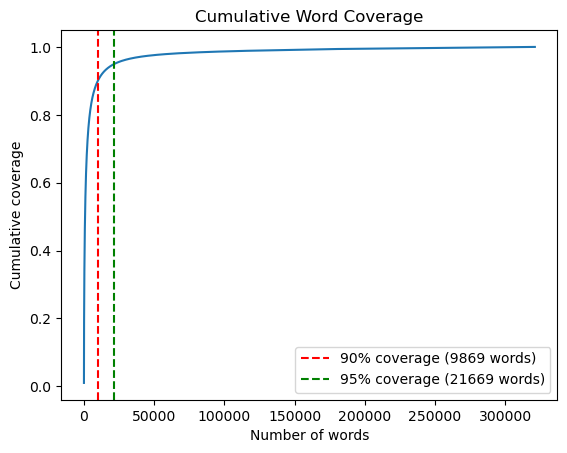

In [19]:
# Get the word index (word -> integer mapping)
word_index = tokenizer.word_index

# Get the word counts (how many times each word appears)
word_counts = tokenizer.word_counts

# Sort words by frequency
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Calculate the cumulative coverage
cumulative_coverage = []
cumulative_count = 0
total_word_count = sum(word_counts.values())

for word, count in sorted_word_counts:
    cumulative_count += count
    cumulative_coverage.append(cumulative_count / total_word_count)

# Calculate num_words for 90% and 95% coverage
coverage_90 = next(i for i, coverage in enumerate(cumulative_coverage) if coverage >= 0.90) + 1
coverage_95 = next(i for i, coverage in enumerate(cumulative_coverage) if coverage >= 0.95) + 1

print(f"Number of words covering 90% of the dataset: {coverage_90}")
print(f"Number of words covering 95% of the dataset: {coverage_95}")

# Plot the cumulative coverage
import matplotlib.pyplot as plt

plt.plot(cumulative_coverage)
plt.xlabel("Number of words")
plt.ylabel("Cumulative coverage")
plt.title("Cumulative Word Coverage")
plt.axvline(x=coverage_90, color='r', linestyle='--', label=f'90% coverage ({coverage_90} words)')
plt.axvline(x=coverage_95, color='g', linestyle='--', label=f'95% coverage ({coverage_95} words)')
plt.legend()
plt.show()



Using the cumulative coverage plot to choose a num_words value that balances vocabulary size and coverage. For this dataset I have selected `21,669` words that cover 95% of the dataset.

In [20]:
# 1. Tokenise the text
# Initialise the tokeniser
tokenizer = Tokenizer(num_words=int(coverage_95), oov_token='<OOV>')  # Adjust num_words based on your dataset size

# Fit the tokeniser on the cleaned text data
tokenizer.fit_on_texts(df['cleaned_text'])

# Convert the cleaned text to sequences
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

# Check the first few sequences to ensure tokenisation is working correctly
print(sequences[:5])

[[46, 642, 324, 3295, 435, 347, 1470, 35, 2715, 8658, 1, 362, 82, 161, 492, 447, 25, 99, 1, 1, 8658, 547, 115, 12055, 4595, 35, 7, 1470, 2993, 300, 982, 103, 181, 284, 463, 5865, 1135, 35, 7, 1470, 1161, 432, 843, 131, 7, 1, 1, 2893, 115, 10100, 982, 2575, 103, 3214, 497, 115, 10100, 13878, 787, 982, 103, 9678, 1, 1, 187, 731, 1111, 103, 2970, 220, 133, 269, 1, 2172, 390, 5467, 5925, 35, 9678, 187, 982, 133, 4630, 1, 982, 103, 5223, 1111, 972, 894, 1, 103, 3544, 867, 133, 12055, 843, 35, 1, 823, 3019, 982, 103, 829, 310, 1072, 486, 497, 453, 6, 18, 2145, 1, 212, 626, 307, 347, 287, 11825, 1, 522, 1, 5528, 131, 152, 2, 705, 1, 2113, 428, 13878, 568, 18, 4, 3403, 1, 1, 9, 4, 481, 2341, 568, 2, 619, 212, 2341, 1915, 2809, 609, 947, 131, 705, 1, 77, 35, 329, 2094, 4169, 260, 463, 1667, 12349, 1470, 660, 1553, 7, 5, 1361, 8515, 9, 30, 84, 6, 837, 1, 1739, 180, 74, 1, 55, 428, 1, 568, 212, 472, 345, 10879, 247, 1153, 10100, 22, 829, 140, 13879, 600, 14020, 600, 2, 83, 463, 1667, 221, 929, 47

90th percentile max_sequence_length set to: 642
95th percentile max_sequence_length set to: 818
First padded sequence: [   46   642   324  3295   435   347  1470    35  2715  8658     1   362
    82   161   492   447    25    99     1     1  8658   547   115 12055
  4595    35     7  1470  2993   300   982   103   181   284   463  5865
  1135    35     7  1470  1161   432   843   131     7     1     1  2893
   115 10100   982  2575   103  3214   497   115 10100 13878   787   982
   103  9678     1     1   187   731  1111   103  2970   220   133   269
     1  2172   390  5467  5925    35  9678   187   982   133  4630     1
   982   103  5223  1111   972   894     1   103  3544   867   133 12055
   843    35     1   823  3019   982   103   829   310  1072   486   497
   453     6    18  2145     1   212   626   307   347   287 11825     1
   522     1  5528   131   152     2   705     1  2113   428 13878   568
    18     4  3403     1     1     9     4   481  2341   568     2   619
   21

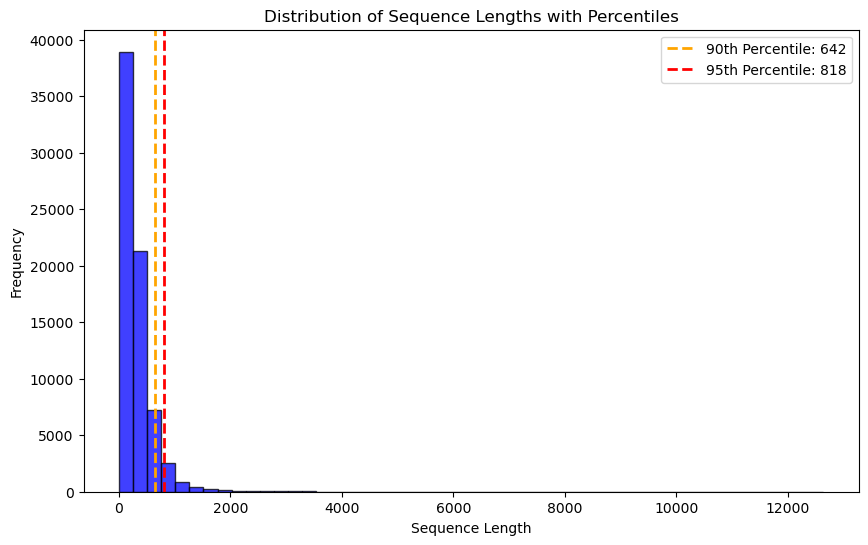

In [21]:
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

# Calculate the lengths of all sequences
sequence_lengths = [len(seq) for seq in sequences]

# Determine the 90th and 95th percentiles
percentile_90 = int(np.percentile(sequence_lengths, 90))
percentile_95 = int(np.percentile(sequence_lengths, 95))

# Print the chosen max_sequence_lengths
print(f"90th percentile max_sequence_length set to: {percentile_90}")
print(f"95th percentile max_sequence_length set to: {percentile_95}")

# Pad the sequences to the 95th percentile length
padded_sequences = pad_sequences(sequences, maxlen=percentile_95, padding='post', truncating='post')

# Verify the padding
print(f"First padded sequence: {padded_sequences[0]}")
print(f"Shape of padded_sequences: {padded_sequences.shape}")

# Plot the distribution of sequence lengths
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.axvline(percentile_90, color='orange', linestyle='dashed', linewidth=2, label=f'90th Percentile: {percentile_90}')
plt.axvline(percentile_95, color='red', linestyle='dashed', linewidth=2, label=f'95th Percentile: {percentile_95}')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths with Percentiles')
plt.legend()
plt.show()

In [22]:
# 2. Padding Sequences

# Determine the maximum sequence length based on your data (e.g., 95th percentile of sequence lengths)
max_sequence_length = int(percentile_95)  # Adjust this value based on the output of the previous step

# Pad the sequences to ensure they are all of the same length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Check the shape and the first few padded sequences to ensure everything looks correct
print(f"Padded sequences shape: {padded_sequences.shape}")
print(padded_sequences[:5])


Padded sequences shape: (72095, 818)
[[  46  642  324 ...    0    0    0]
 [1742  211   58 ...    0    0    0]
 [5496  556  392 ...    0    0    0]
 [7692 9999  899 ...    0    0    0]
 [6981   71    1 ...    0    0    0]]


In [23]:
# Create the directory if it does not exist
os.makedirs('../data/processed', exist_ok=True)

# Save the padded sequences in HDF5 format
with h5py.File('../data/processed/padded_sequences.h5', 'w') as f:
    f.create_dataset('padded_sequences', data=padded_sequences)

# Save the tokeniser separately as Pickle (HDF5 is not as straightforward for Python objects like the tokenizer)
with open('../data/processed/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Save the processed DataFrame
df.to_hdf('../data/processed/processed_data.h5', key='df', mode='w')

print("Data has been serialised and saved in the '../data/processed' folder.")


Data has been serialised and saved in the '../data/processed' folder.
